In [184]:
import matplotlib.pyplot as plt
import  numpy as np
import  pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import seaborn as sns

from imblearn.over_sampling import RandomOverSampler
import random
import tensorflow as tf
import warnings


from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import LearningCurveDisplay, learning_curve, KFold, cross_val_score
from numpy.typing import ArrayLike






warnings.simplefilter(action='ignore', category=FutureWarning)
sns.set_theme(style="ticks")
sns.set_palette("viridis")

### Helper functions

In [185]:
df_data= pd.read_csv(os.path.join('..','data', 'cs-training.csv'))
def cleanData(df):
    '''
    Args:
            df (Pandas DataFrame): A pandas DataFrame to be cleaned and split

    Returns:
            X_train (Pandas DataFrame): Pandas DataFrame with a portion of 80% of the dataframe through *train_test_split* sklearn method 
            X_test (Pandas DataFrame): Pandas DataFrame with a portion of 20% of the dataframe through *train_test_split* sklearn method 
            y_train (Pandas Series): Pandas Series with a portion of 80% of the dataframe through *train_test_split* sklearn method
            y_test (Pandas Series): Pandas Series with a portion of 20% of the dataframe through *train_test_split* sklearn method


    '''
    df.rename(columns={"Unnamed: 0": "ID",
                            "RevolvingUtilizationOfUnsecuredLines": "balance_divided_creditlimit", 
                            "NumberOfTime60-89DaysPastDueNotWorse": "number_times_latepay60-89"}, inplace=True)

    df.dropna(inplace=True)
    df= df[df['age'] >=18 ]
    df= df[df['NumberOfTime30-59DaysPastDueNotWorse']<96  ]
    df= df[df['balance_divided_creditlimit']<=1]

    
    garbage_columns= ["ID","SeriousDlqin2yrs", "NumberOfTime30-59DaysPastDueNotWorse"]
    X_train, X_test, y_train, y_test = train_test_split( df.drop(garbage_columns, axis=1), df["SeriousDlqin2yrs"], test_size=0.2)
    return X_train, X_test, y_train, y_test


def overSampling(X: pd.DataFrame | ArrayLike, y: pd.Series | ArrayLike):
    '''
    Args:
        X (Pandas DataFrame | ArrayLike): Pandas DataFrame to use a Over-sampling technique to avoid unbalanced dataset
        Y (Pandas Series | ArrayLike): Pandas Series to use a Over-sampling technique to avoid unbalanced dataset
    Returns:
        X (Pandas DataFrame | ArrayLike): Pandas DataFrame with over-sampling aplied
        Y (Pandas Series | ArrayLike): Pandas Series with over-sampling aplied

    '''
    ros = RandomOverSampler(random_state=0)
    X_resampled, y_resampled = ros.fit_resample(X, y)
    
    return X_resampled, y_resampled



def plot_roc(y_true: pd.Series | ArrayLike, y_score: pd.Series | ArrayLike):
    '''
    Args:
        y_true (Pandas Series | Numpy Array | ArrayLike): Actual Y from your dataset
        y_score (Pandas Series | Numpy Array | ArrayLike): Probabily estimator of your dataset
    Returns:
        A Roc/Auc graph from your dataset

    '''


    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = roc_auc_score(y_true, y_score)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()



def plot_learningCurve(model, X_train: pd.DataFrame | ArrayLike, y_train: pd.Series | ArrayLike):
    '''
    Args:
        model (estimator): object type that implements the “fit” method
        X_train (Pandas DataFrame | ArrayLike): your training data without actual Y
        y_train (Pandas Series | ArrayLike): your training Y data
    Returns:
        A plot of a graph of your leaning curve through epochs
    
    '''

    train_sizes, train_scores, test_scores = learning_curve(
        model, X_train, y_train)
    display = LearningCurveDisplay(train_sizes=train_sizes,
        train_scores=train_scores, test_scores=test_scores, score_name="Score")
    display.plot()
    plt.show()


def plot_confussion(Y: pd.Series | ArrayLike, y_pred: pd.Series | ArrayLike):
    '''
    Args:
        Y (Pandas Series | ArrayLike): Actual Y from your dataset
        y_pred (Pandas Series | ArrayLike): Y predicted of your model
    Returns:
        A plot of a graph of the confussion matrix at *sns.heatmap* with percentage
    
    '''
    confi = confusion_matrix(Y, y_pred)
    plt.figure(figsize=(10, 10))

    confi = (confi/confi.sum())*100
    print(confi)
    formatted_confi = np.vectorize(lambda x: f"{x:.2f}%")(confi)
    sns.heatmap(confi, annot=formatted_confi, fmt="", linewidths=.5, cmap='cividis', xticklabels=[ 'FN','TN'], yticklabels=['TP', 'FN'])
    

    plt.show()

def plot_confussion_subplots(Y: pd.Series | ArrayLike, y_pred: pd.Series | ArrayLike, ax=0):
    '''
    Args:
        Y (Pandas Series | ArrayLike): Actual Y from your dataset
        y_pred (Pandas Series | ArrayLike): Y predicted of your model
        ax (int) : The number or a list to use while plotting more than 1 chart (like axs[1,0])
    Returns:
        Plots a chart of the confussion matrix at *sns.heatmap* with percentage
    
    '''
    confi = confusion_matrix(Y, y_pred)
    confi = (confi/confi.sum())*100
    formatted_confi = np.vectorize(lambda x: f"{x:.2f}%")(confi)
    sns.heatmap(confi, annot=formatted_confi, fmt="", linewidths=.5, cmap='cividis', xticklabels=[ 'FN','TN'], yticklabels=['TP', 'FN'], ax=ax)
    


In [186]:
X_train, X_test, y_train, y_test = cleanData(df_data)
########################################################
X_train, y_train = overSampling(X_train, y_train)
X_test, y_test= overSampling(X_test, y_test)
X_train

,balance_divided_creditlimit,age,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,number_times_latepay60-89,NumberOfDependents
0,0.262719,59,0.252541,7083.0,22,1,0,0,0.0
1,0.422890,44,0.090126,7200.0,9,0,0,0,2.0
2,0.989402,45,0.659367,6666.0,9,0,2,0,0.0
3,0.007911,62,0.227629,6000.0,5,0,1,0,1.0
4,0.197527,42,0.313305,11250.0,8,0,2,0,2.0
...,...,...,...,...,...,...,...,...,...
176081,0.103185,61,0.493918,10687.0,22,1,2,0,1.0
176082,0.876092,55,0.608607,6900.0,30,0,2,0,0.0
176083,0.067828,52,0.269723,1875.0,5,0,2,0,0.0
176084,0.998901,27,0.272681,1950.0,2,1,0,0,0.0


In [187]:
y_train

0         0
1         1
2         0
3         0
4         0
         ..
176081    1
176082    1
176083    1
176084    1
176085    1
Name: SeriousDlqin2yrs, Length: 176086, dtype: int64

## 5.0 DATA PRE-PROCESSING

#### 5.1 -   Normalization

In [188]:

real_columns= X_train.columns
X_train= pd.DataFrame(StandardScaler().fit_transform(X_train), columns=real_columns)
X_test = pd.DataFrame(StandardScaler().fit_transform(X_test), columns=real_columns)


In [189]:
X_train

,balance_divided_creditlimit,age,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,number_times_latepay60-89,NumberOfDependents
0,-0.516737,0.714430,-0.062186,0.085194,2.439170,0.752670,-0.830319,-0.329381,-0.785814
1,-0.091064,-0.365893,-0.062621,0.097253,0.054114,-0.341988,-0.830319,-0.329381,0.891144
2,1.414511,-0.293872,-0.061094,0.042214,0.054114,-0.341988,0.711239,-0.329381,-0.785814
3,-1.193920,0.930495,-0.062252,-0.026431,-0.679750,-0.341988,-0.059540,-0.329381,0.052665
4,-0.689994,-0.509937,-0.062023,0.514687,-0.129352,-0.341988,0.711239,-0.329381,0.891144
...,...,...,...,...,...,...,...,...,...
176081,-0.940718,0.858474,-0.061538,0.456658,2.439170,0.752670,0.711239,-0.329381,0.052665
176082,1.113375,0.426344,-0.061230,0.066332,3.906898,-0.341988,0.711239,-0.329381,-0.785814
176083,-1.034685,0.210279,-0.062139,-0.451595,-0.679750,-0.341988,0.711239,-0.329381,-0.785814
176084,1.439756,-1.590261,-0.062132,-0.443864,-1.230148,0.752670,-0.830319,-0.329381,-0.785814


## 6.0 - Model Training

#### 6.1 -  KNN Classifier

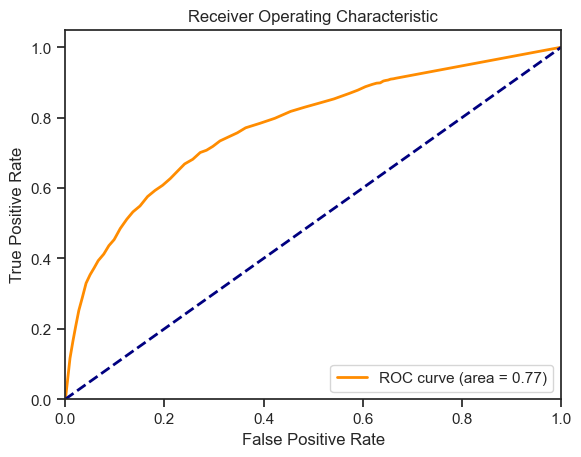

In [190]:
models_accuracy = pd.DataFrame(columns=['KNN', 'RForest', 'SVM', 'Neural Network' ])
knn = KNeighborsClassifier(n_neighbors=50).fit(X_train, y_train)
y_knn_n = knn.predict(X_test)
y_prob_knn = knn.predict_proba(X_test)[:, 1]

accuracy_knn = (accuracy_score(y_test, y_knn_n))*100
roc_knn= roc_auc_score(y_test, y_prob_knn)

plot_roc(y_test, y_prob_knn)



#### 6.2 -  Random Florest Classifier

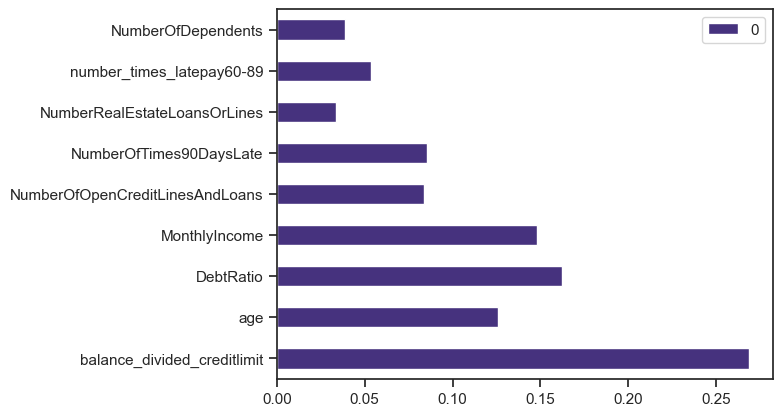

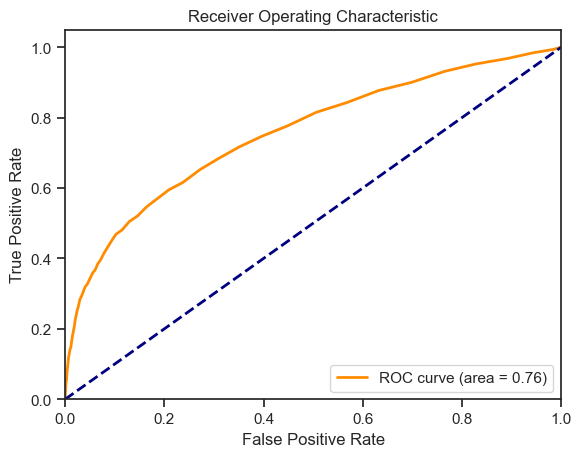

[[21854   207]
 [19008  3053]]


In [191]:
# Model
forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, y_train)

#Predicts
y_RFC= forest.predict(X_test)
y_pred_prob = forest.predict_proba(X_test)[:, 1]

#Metrics
accuracy_RFC= (accuracy_score(y_test, y_RFC))*100
roc_rfc=roc_auc_score(y_test, y_pred_prob)

#plots

importance = forest.feature_importances_
global_importances = pd.DataFrame(importance, index=X_train.columns)


global_importances.plot.barh()
plot_roc(y_test, y_pred_prob)

print(confusion_matrix(y_test, y_RFC))

plt.show()

#### 6.3 - SVM

[[38.33461765 11.66538235]
 [15.16477041 34.83522959]]


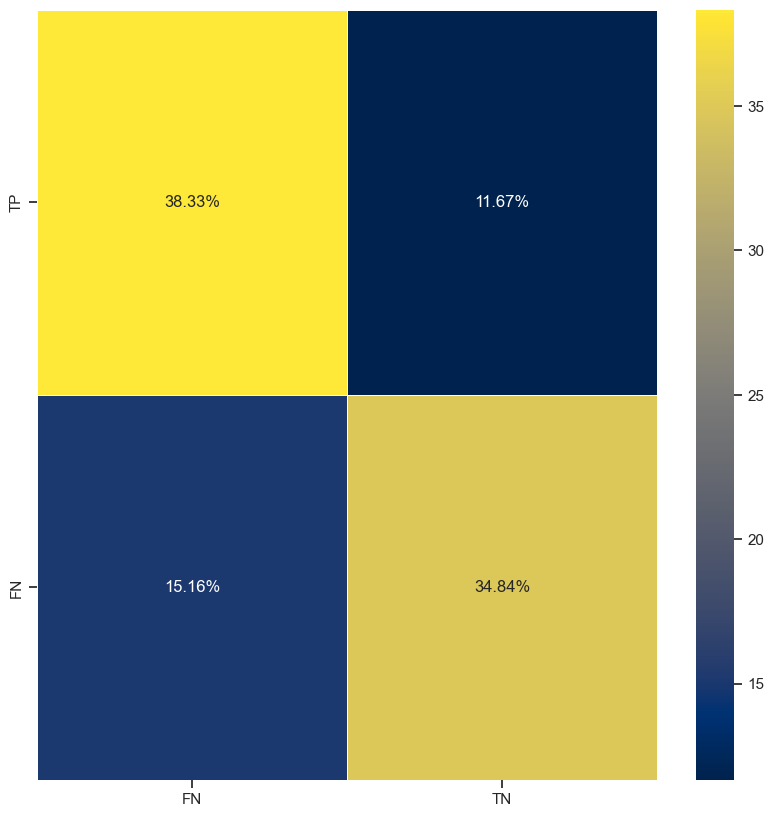

73.16984724173882

In [192]:

svm_model = LinearSVC(random_state=0, C=0.1, penalty='l2')  
svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)


plot_confussion(y_test, y_pred )
cm_rf= classification_report(y_test, y_pred)
accuracy_SVM= (accuracy_score(y_pred, y_test))*100
accuracy_SVM

##### Using K-fold Cross validation on SVM


In [193]:

from sklearn.model_selection import GridSearchCV


# Definindo o espaço de busca
param_grid = {'C': [0.1, 1, 10],
              'penalty': ['l1', 'l2']}

# Criando o objeto GridSearchCV
grid = GridSearchCV(svm_model, param_grid, cv=5)

# Ajustando o modelo aos dados
grid.fit(X_train, y_train)

# Melhores parâmetros
print(grid.best_params_)





{'C': 1, 'penalty': 'l1'}


### Description
- Support Vector Machines (SVM)

#### 6.4 -  Neural networks

In [194]:
model =tf.keras.Sequential(
[tf.keras.layers.Input(shape=(9,)),
 tf.keras.layers.Dense(units=50, activation='relu', ),
 tf.keras.layers.Dense(units=100, activation='relu', ),
 tf.keras.layers.Dropout(0.2),
 tf.keras.layers.Dense(units=50, activation='relu' ),
 tf.keras.layers.Dense(units=1, activation='sigmoid', )
]
)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='binary_crossentropy',  metrics=[tf.keras.metrics.BinaryAccuracy()])
model.fit(X_train, y_train, batch_size=32, epochs=5)

Epoch 1/5
5503/5503 ━━━━━━━━━━━━━━━━━━━━ 4s 530us/step - binary_accuracy: 0.7454 - loss: 0.5298
Epoch 2/5
5503/5503 ━━━━━━━━━━━━━━━━━━━━ 3s 537us/step - binary_accuracy: 0.7507 - loss: 0.5177
Epoch 3/5
5503/5503 ━━━━━━━━━━━━━━━━━━━━ 3s 550us/step - binary_accuracy: 0.7524 - loss: 0.5142
Epoch 4/5
5503/5503 ━━━━━━━━━━━━━━━━━━━━ 3s 545us/step - binary_accuracy: 0.7526 - loss: 0.5133
Epoch 5/5
5503/5503 ━━━━━━━━━━━━━━━━━━━━ 3s 530us/step - binary_accuracy: 0.7536 - loss: 0.5116


In [195]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 50)             │           500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 100)            │         5,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,105 (125.41 KB)

 Trainable params: 10,701 (41.80 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 21,404 (83.61 KB)

In [196]:
y_nn=model.predict(X_test)
y_pred_nn = (y_nn >= 0.6).astype(int)
acc_NN= (accuracy_score(y_pred_nn, y_test ))*100
print(f"Model Accuracy: {acc_NN}")

1379/1379 ━━━━━━━━━━━━━━━━━━━━ 1s 395us/step
Model Accuracy: 72.32219754317573


In [197]:
y_test.shape

(44122,)

In [198]:
report_knn= classification_report(y_test, y_knn_n, output_dict=True)
report_rfc= classification_report(y_test, y_RFC, output_dict=True)
report_svm= classification_report(y_test, y_pred, output_dict=True)
report_nn= classification_report(y_test, y_pred, output_dict=True)
print('----------  KNN  ----------\n')
print(pd.DataFrame(report_knn).T)
print('----------  Random Florest Classifier  ----------\n')
print(pd.DataFrame(report_rfc).T)
print('----------  Support Vector Machines (SVM)  ----------\n')
print(pd.DataFrame(report_svm).T)
print('----------  Neural Network  ----------')
print(pd.DataFrame(report_nn).T)

----------  KNN  ----------

              precision    recall  f1-score       support
0              0.700009  0.742623  0.720686  22061.000000
1              0.725939  0.681746  0.703149  22061.000000
accuracy       0.712184  0.712184  0.712184      0.712184
macro avg      0.712974  0.712184  0.711917  44122.000000
weighted avg   0.712974  0.712184  0.711917  44122.000000
----------  Random Florest Classifier  ----------

              precision    recall  f1-score       support
0              0.534825  0.990617  0.694627  22061.000000
1              0.936503  0.138389  0.241144  22061.000000
accuracy       0.564503  0.564503  0.564503      0.564503
macro avg      0.735664  0.564503  0.467885  44122.000000
weighted avg   0.735664  0.564503  0.467885  44122.000000
----------  Support Vector Machines (SVM)  ----------

              precision    recall  f1-score       support
0              0.716543  0.766692  0.740770  22061.000000
1              0.749135  0.696705  0.721969  22061.00

-------------------------------------- Classification Confussion Matrix in % --------------------------------------


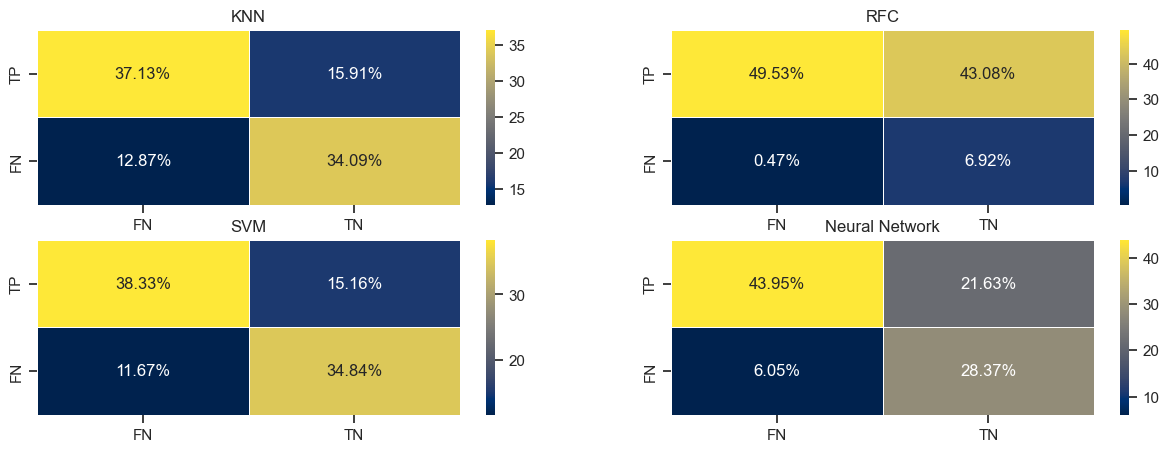

In [199]:
fig, axs =plt.subplots(2, 2, figsize=(15, 5))
plot_confussion_subplots(y_knn_n, y_test, ax=axs[0,0])
axs[0,0].set_title('KNN')

plot_confussion_subplots(y_RFC, y_test, ax=axs[0,1])
axs[0,1].set_title('RFC')
plot_confussion_subplots(y_pred, y_test, ax=axs[1,0])
axs[1,0].set_title('SVM')
plot_confussion_subplots(y_pred_nn, y_test, ax=axs[1,1])
axs[1,1].set_title('Neural Network')

print('-'*38, 'Classification Confussion Matrix in %' ,'-'*38)
plt.show()

In [200]:
models_accuracy.loc[0]= {'KNN':f'{accuracy_knn:.2f}%', 'RForest': f'{accuracy_RFC:.2f}%', 'SVM': f'{accuracy_SVM:.2f}%', 'Neural Network': f'{acc_NN:.2f}%'}
models_accuracy

,KNN,RForest,SVM,Neural Network
0,71.22%,56.45%,73.17%,72.32%


### Save the model

In [201]:
import pickle
path_model= os.path.join('..', 'model', 'model_svm.pkl')
# save
with open(path_model,'wb') as f:
    pickle.dump(svm_model, f)


### Load the model

In [218]:
with open(path_model, 'rb') as f:
    clf2 = pickle.load(f)
print(pd.DataFrame(y_train[4:8]))
clf2.predict(X_train.iloc[4:8])


   SeriousDlqin2yrs
4                 0
5                 0
6                 0
7                 0


array([0, 1, 0, 0], dtype=int64)

# Final Considerations

- Although we have a relatively simple data cleaning and modeling, we've got incredible results!
- The worst model performed over the training and test examples was the Random Florest Classifier (RFC) with almost 50% of accuracy. A god point of view is that RFC got a **0.78 score** of AUC but is awful with accuracy and has an f1-score (in training examples where y = True) of **0.024** !!!

- For note: by just changing the normalization for Standard Scaler I've got a big I received a huge increase, especially in accuracy (not documented it above)